In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from scipy import sparse
from sklearn.decomposition import PCA, TruncatedSVD

# Load and Preprocess Data
Filter our users based on total play count and drop unnecessary columns.


In [2]:
user_df = pd.read_csv("filtered_user_df.csv")
user_df.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], inplace=True)


In [3]:
user_df.head()

,user,artist_name,play_count,artist_url
0,nyancrimew,Jasmine Thompson,7559,https://www.last.fm/music/Jasmine+Thompson
1,nyancrimew,Eminem,5851,https://www.last.fm/music/Eminem
2,nyancrimew,Watsky,3044,https://www.last.fm/music/Watsky
3,nyancrimew,Linkin Park,2938,https://www.last.fm/music/Linkin+Park
4,nyancrimew,twenty one pilots,1849,https://www.last.fm/music/twenty+one+pilots


In [4]:
# Getting total play counts for users and filtered some out 

user_total_play = (
    user_df.groupby("user")["play_count"]
    .sum()
    .reset_index(name="total_play_count")
)
filtered_users = user_total_play[
    user_total_play["total_play_count"] >= 125000
]["user"]
filtered_df = user_df[user_df["user"].isin(filtered_users)]
filtered_df['play_count'] = filtered_df['play_count'].map(lambda x: 1)

/tmp/ipykernel_9916/891740531.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['play_count'] = filtered_df['play_count'].map(lambda x: 1)


In [5]:
filtered_df.head()

,user,artist_name,play_count,artist_url
1259,ext_beck,Linkin Park,1,https://www.last.fm/music/Linkin+Park
1260,ext_beck,Coldplay,1,https://www.last.fm/music/Coldplay
1261,ext_beck,Moby,1,https://www.last.fm/music/Moby
1262,ext_beck,Avril Lavigne,1,https://www.last.fm/music/Avril+Lavigne
1263,ext_beck,Muse,1,https://www.last.fm/music/Muse


Convert this to a sparse matrix. Start by mapping users and artists to a unique numeric value.

In [6]:
user_ids = filtered_df["user"].unique()
artist_names = filtered_df["artist_name"].unique()

user_to_idx = {user: i for i, user in enumerate(user_ids)}
artist_to_idx = {artist: j for j, artist in enumerate(artist_names)}

# Convert rows to (row index, column index, value) tuples
rows = filtered_df["user"].map(user_to_idx)
cols = filtered_df["artist_name"].map(artist_to_idx)
values = filtered_df["play_count"]
sparse_matrix = sparse.coo_matrix(
    (values, (rows, cols)), shape=(len(user_ids), len(artist_names))
)


In [7]:
# View sparse matrix
dense_matrix = sparse_matrix.todense()

row, col, data = sparse.find(sparse_matrix)

for r, c, d in zip(row[:10], col[:10], data[:10]):
    print(f"User index: {r}, Artist index: {c}, Play count: {d}")


User index: 0, Artist index: 0, Play count: 1
User index: 9, Artist index: 0, Play count: 1
User index: 11, Artist index: 0, Play count: 1
User index: 13, Artist index: 0, Play count: 1
User index: 18, Artist index: 0, Play count: 1
User index: 19, Artist index: 0, Play count: 1
User index: 26, Artist index: 0, Play count: 1
User index: 28, Artist index: 0, Play count: 1
User index: 30, Artist index: 0, Play count: 1
User index: 36, Artist index: 0, Play count: 1


Load in the artist location data.

In [8]:
with open('artist_location_codes.json', 'r') as file:
    artist_locations = json.load(file)
priveleged_locations = ['US', 'CA', 'GB']

# Collabroative Filtering
Use `TruncatedSVD`.

**Collaborative Filtering**: Assumption is that if users $A$ and $B$ rate items similarly, $A$ is more likely to have $B$'s opinion on an item (artist) than that of another randomly chosen user.

Use **SVD** to decompose the original sparse matrix (users' interactions with items, i.e., play counts) into lower-dimensional matrices, capturing latent factors with users and items.

In [9]:
num_components = 50  # Number of latent factors to represent users and items

# Matrix factorization with TruncatedSVD
svd = TruncatedSVD(n_components=num_components, random_state=42)

user_features = svd.fit_transform(
    sparse_matrix
)  # Represent the users in the reduced latent factor space.
item_features = svd.components_
user_ratings = np.dot(user_features, item_features)

## Visualize Artist Latent Features with PCA

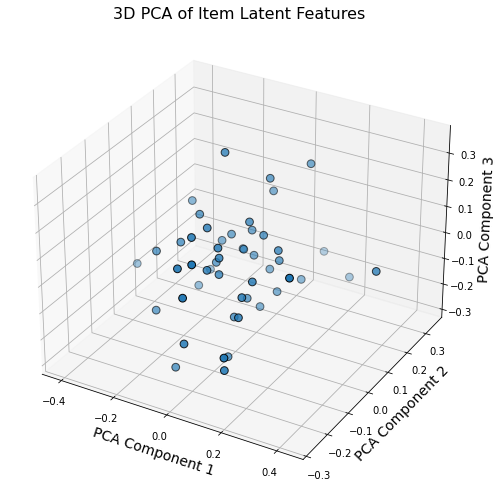

In [10]:
def visualize_latent_features(
    _item_features: np.ndarray, item_labels: list[int] = None
) -> None:
    pca = PCA(n_components=3)
    reduced_features = pca.fit_transform(_item_features)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")

    if item_labels is not None:
        for i, label in enumerate(item_labels):
            ax.scatter(
                reduced_features[i, 0],
                reduced_features[i, 1],
                reduced_features[i, 2],
                label=label,
                edgecolor="k",
                s=60,
            )
        ax.legend(fontsize="small", loc="best")
    else:
        ax.scatter(
            reduced_features[:, 0],
            reduced_features[:, 1],
            reduced_features[:, 2],
            edgecolor="k",
            s=60,
        )

    ax.set_xlabel("PCA Component 1", fontsize=14)
    ax.set_ylabel("PCA Component 2", fontsize=14)
    ax.set_zlabel("PCA Component 3", fontsize=14)
    ax.set_title("3D PCA of Item Latent Features", fontsize=16)
    plt.tight_layout()
    plt.show()


visualize_latent_features(item_features)


In [11]:
# idx_to_artist = {idx: artist for artist, idx in artist_to_idx.items()}


# def recommend_artists(
#     _user_id: int,
#     _user_features: np.ndarray,
#     _item_features: np.ndarray,
#     top_n: int = 5,
#     underrepresented_weight = 1
# ) -> list[str]:
#     # Convert 
#     # Predicted rating is the dot product of `user_factors` and `item_factors`. Will be the same shape as the original matrix, and the element will represent the predicted interaction (play count) with an artist.
#     predicted_ratings = np.dot(_user_features, _item_features)
#     user_ratings = predicted_ratings[_user_id, :]
#     print(_item_features.shape)
#     # Calculate reweighting vector TODO: There has to be a less computationally intense way of calculating this
#     reweighting_vec = np.array([(1 if artist_locations[artist] in priveleged_locations else underrepresented_weight) for artist in artist_names])
#     reweighted_ratings = user_ratings * reweighting_vec
#     recommended_item_idx = np.argsort(reweighted_ratings)[::-1]
#     # This is horribly inefficient, optimize
#     recommended_artist_names = [
#         idx_to_artist[idx] for idx in recommended_item_idx
#     ]
#     username = idx_to_user[_user_id]
#     user_listened_artists = filtered_df[filtered_df['user'] == username]['artist_name']
#     for artist in user_listened_artists:
#         recommended_artist_names.remove(artist)
#     return recommended_artist_names[:top_n]


In [12]:
idx_to_artist = {idx: artist for artist, idx in artist_to_idx.items()}


def recommend_artists(
    _user_liked_artists: list,
    _item_features: np.ndarray,
    top_n: int = 5,
    underrepresented_weight = 1
) -> list[str]:
    # Convert liked artists to user features
    user_info_array = np.array([[int(artist in _user_liked_artists) for artist in artist_names]])
    user_features = svd.transform(user_info_array)
    # Predicted rating is the dot product of `user_factors` and `item_factors`. Will be the same shape as the original matrix, and the element will represent the predicted interaction (play count) with an artist.
    user_ratings = np.dot(user_features, _item_features)
    # Calculate reweighting vector TODO: There has to be a less computationally intense way of calculating this
    reweighting_vec = np.array([(1 if artist_locations[artist] in priveleged_locations else underrepresented_weight) for artist in artist_names])
    reweighted_ratings = user_ratings * reweighting_vec
    user_artist_idxs = [artist_to_idx[artist] for artist in get_user_liked_artists(0)]
    for idx in user_artist_idxs:
        reweighted_ratings[0][idx] = 0
    recommended_item_idx = np.argsort(reweighted_ratings[0])[::-1]
    # match = user_ratings[0][recommended_item_idx[:top_n]].sum() / len(_user_liked_artists) # THIS IS NOT CORRECT
    # This is horribly inefficient, optimize
    recommended_artist_names = [
        idx_to_artist[idx] for idx in recommended_item_idx
    ]
    return recommended_artist_names[:top_n]#, match


In [13]:
# Example
idx_to_user = {idx: user for user, idx in user_to_idx.items()}

def get_user_liked_artists(user_id):
    # Returns a list of names of artists the user likes
    liked_artists = filtered_df[filtered_df['user'] == filtered_df['user'].iloc[user_id]]['artist_name'].array
    return liked_artists

def recommend_for_user(user_id: int, top_n: int) -> None:
    recommended_artists = recommend_artists(
        get_user_liked_artists(user_id), item_features, top_n
    )
    username = idx_to_user[user_id]
    print(f"Recommended artists for user {username}: {recommended_artists}")


recommend_for_user(0, 10)

# TODO: Solve the David Guetta Problem

Recommended artists for user ext_beck: ['Daft Punk', 'Panic! at the Disco', 'Fall Out Boy', 'The Offspring', 'My Chemical Romance', 'Kelly Clarkson', 'OneRepublic', 'Ed Sheeran', 'Oasis', 'Tove Lo']


In [22]:
# avg_match is the average of the match scores given by the model to the artists it recommends. We want to maximize this
# underrepresented_proportion is the percentage of recommended artists that are from underrepresented countries. We want to maximize this
def calc_metrics(top_n = 10, underrepresented_weight = 1):
    num_users = user_features.shape[0]
    underrepresented_count = 0
    total_artist_count = 0
    total_match = 0
    for i in range(num_users):
        # if i % 100 == 0:
        #     print(i)

        user_liked_artists = get_user_liked_artists(i)
        rating_row = user_ratings[i]
        user_artist_idxs = [artist_to_idx[artist] for artist in user_liked_artists]
        reweighting_vec = np.array([(1 if artist_locations[artist] in priveleged_locations else underrepresented_weight) for artist in artist_names])
        reweighted_ratings = rating_row * reweighting_vec
        for idx in user_artist_idxs:
            reweighted_ratings[idx] = 0
        recommended_item_idx = np.argsort(reweighted_ratings)[::-1]
        match = user_ratings[i][recommended_item_idx[:top_n]].sum() / len(user_liked_artists)
        total_match += match
        
        underrepresented_artists = [artist_locations[idx_to_artist[idx]] not in priveleged_locations for idx in recommended_item_idx[:top_n]]
        underrepresented_count += sum(underrepresented_artists)
        total_artist_count += len(underrepresented_artists)
        

    avg_match = total_match / num_users
    underrepresented_proportion = underrepresented_count / total_artist_count
    return avg_match, underrepresented_proportion

In [23]:
calc_metrics(10, 1)

(0.15162519582567385, 0.2206128938999711)

In [16]:
calc_metrics(10, 2)

(0.14387527428310276, 0.448077479040185)

In [19]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed

def grid_search(weights, top_n):
    results = []

    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(calc_metrics, top_n, weight) for weight in weights]
        
        for future in as_completed(futures):
            weight = futures[future]
            avg_match, underrepresented_proportion = future.result()
            results.append((weight, avg_match, underrepresented_proportion))

    results.sort(key=lambda x: (x[1], x[2] > your_diversity_threshold), reverse=True)
    best_weight, best_score, best_diversity = results[0]

    return best_weight, best_score, best_diversity

weight_options = np.linspace(1, 2, num=20) 
top_n = 10 
your_diversity_threshold = 0.2 

best_weight, best_score, best_diversity = grid_search(weight_options, top_n)
print(f"Best weight: {best_weight}, Avg Match Score: {best_score}, Diversity: {best_diversity}")


TypeError: list indices must be integers or slices, not Future

In [ ]:
def grid_search(start, end, steps, evaluate_recommendations, *args):
    best_weight = None
    best_relevance = -float('inf')
    best_diversity = -float('inf')
    
    for weight in np.linspace(start, end, steps):
        relevance, diversity = evaluate_recommendations(weight, *args)
        
        if relevance > best_relevance and diversity > your_diversity_threshold:
            best_relevance = relevance
            best_diversity = diversity
            best_weight = weight
            
    return best_weight, best_relevance, best_diversity

best_weight, relevance, diversity = grid_search(
    start=1.0, 
    end=2.0, 
    steps=20, 
    evaluate_recommendations=my_evaluate_function,
    other_args_if_necessary
)

print(f"Best weight: {best_weight}, Relevance: {relevance}, Diversity: {diversity}")


In [ ]:
def grid_search(weights, top_n):
    best_weight = None
    best_score = None
    best_diversity = None

    for weight in weights:
        avg_match, underrepresented_proportion = calc_metrics(top_n, weight)
        
        if avg_match > best_score and underrepresented_proportion > your_diversity_threshold:
            best_score = avg_match
            best_weight = weight
            best_diversity = underrepresented_proportion

    return best_weight, best_score, best_diversity

weight_options = np.linspace(1, 2, num=20) 
top_n = 10 
your_diversity_threshold = 0.2 


best_weight, best_score, best_diversity = grid_search(weight_options, top_n)
print(f"Best weight: {best_weight}, Avg Match Score: {best_score}, Diversity: {best_diversity}")

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
import numpy as np

class DebiasedRecommender(BaseEstimator, TransformerMixin):
    def __init__(self, underrepresented_weight=1.0):
        self.underrepresented_weight = underrepresented_weight

    def fit(self, X, y=None):
        
        return self

    def predict(self, X):
        
        return weighted_recommendations(X, self.underrepresented_weight)

    def score(self, X, y=None):
        
        relevance, diversity = calc_metrics_based_on_weight(X, self.underrepresented_weight)

        return relevance + diversity 

def calc_metrics_based_on_weight(user_features, weight):

    return None 

recommender = DebiasedRecommender()

param_grid = {'underrepresented_weight': np.linspace(1, 2, 10)}


grid_search = GridSearchCV(estimator=recommender, param_grid=param_grid, scoring='accuracy')  # Use your scoring method

user_features_data = user_features
grid_search.fit(user_features_data)


best_weight = grid_search.best_params_['underrepresented_weight']
print(f"The best weight is: {best_weight}")


In [26]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

class DebiasedRecommender(BaseEstimator, TransformerMixin):
    def __init__(self, underrepresented_weight=1.0):
        self.underrepresented_weight = underrepresented_weight
    
    def fit(self, X, y=None):

        return self
    
    def score(self, X, y=None):

        avg_match, underrepresented_proportion = calc_metrics(X, self.underrepresented_weight)

        return avg_match + underrepresented_proportion


scorer = make_scorer(DebiasedRecommender.score, greater_is_better=True)


param_grid = {
    'underrepresented_weight': np.linspace(1.0, 2.0, 20) 
}

grid_search = GridSearchCV(estimator=DebiasedRecommender(), 
                           param_grid=param_grid, 
                           scoring=scorer)  

grid_search.fit(user_features)

print("Best underrepresented_weight: ", grid_search.best_params_['underrepresented_weight'])


Best underrepresented_weight:  1.0


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 685, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 685, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_s

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


class DebiasedRecommender(BaseEstimator, TransformerMixin):
    def __init__(self, underrepresented_weight=1.0):
        self.underrepresented_weight = underrepresented_weight
    
    def fit(self, X, y=None):
        
        return self
    
    def score(self, X, y=None):

        avg_match, underrepresented_proportion = calc_metrics(X, self.underrepresented_weight)

        return avg_match + underrepresented_proportion


def metrics_scorer(estimator, X):
    return estimator.score(X)

def custom_scorer(estimator, X, y=None):
    # Call the score method of your custom estimator, which internally calls calc_metrics
    return estimator.score(X)

def calc_metrics(user_features, underrepresented_weight):
    num_users = user_features.shape[0]
    underrepresented_count = 0
    total_artist_count = 0
    total_match = 0
    
    for i in range(num_users):
        user_liked_artists = get_user_liked_artists(i)
        rating_row = user_ratings[i]
        user_artist_idxs = [artist_to_idx[artist] for artist in user_liked_artists]
        reweighting_vec = np.array([(1 if artist_locations[artist] in privileged_locations else underrepresented_weight) for artist in artist_names])
        
        weighted_ratings = rating_row * reweighting_vec
        weighted_ratings[user_artist_idxs] = 0
        recommended_item_idxs = np.argsort(weighted_ratings)[-top_n:][::-1]
        
        match = np.sum(rating_row[recommended_item_idxs]) / len(user_liked_artists)
        total_match += match
        
        underrepresented_artists = [idx for idx in recommended_item_idxs if artist_locations[idx_to_artist[idx]] not in privileged_locations]
        underrepresented_count += len(underrepresented_artists)
        total_artist_count += top_n

    avg_match = total_match / num_users
    underrepresented_proportion = underrepresented_count / total_artist_count
    return avg_match, underrepresented_proportion

scorer = make_scorer(custom_scorer, greater_is_better=True)


param_grid = {
    'underrepresented_weight': np.linspace(1.0, 2.0, 20)  
}


grid_search = GridSearchCV(estimator=DebiasedRecommender(), 
                           param_grid=param_grid, 
                           scoring=scorer) 


grid_search.fit(user_features)


print("Best underrepresented_weight: ", grid_search.best_params_['underrepresented_weight'])

Best underrepresented_weight:  1.0


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 685, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 685, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_s

- Running gridsearchcv doesn't work without the hyperparameters and stuff
- trying to run it manually